# Prelim

In [1]:
import re
import pandas as pd
import os
import pickle
import seaborn as sns
import numpy as np
import sys
sys.path.append("/Users/jiahang/Documents/dagma/src/dagma/")
import utils
import matplotlib.pyplot as plt
import utils_dagma
import networkx as nx

def load_data(n_nodes, seed, version_path):
    root_path="/Users/jiahang/Documents/dagma/src/dagma/simulated_data/"
    with open(os.path.join(root_path, f'{version_path}/W/W_{seed}_0.pkl'), 'rb') as f:
        W = pickle.load(f)
    with open(os.path.join(root_path, f'{version_path}/X/X_1.pkl'), 'rb') as f:
        X = pickle.load(f)
    W_est = W['W_est']
    W = W['W_est'][:, :n_nodes]
    Z = np.abs(W[:n_nodes]) - np.abs(W[n_nodes:])
    W_true = X['W_true']
    X = X['X']
    B_true = (W_true != 0)
    
    return X, B_true, W_est, W_true

def get_block(data, n_nodes=20, index=11, extract=None):
    data_dict = {
        11: data[:n_nodes, :n_nodes],
        12: data[:n_nodes, n_nodes:],
        21: data[n_nodes:, :n_nodes],
        22: data[n_nodes:, n_nodes:]
    }
    
    return data_dict[index]

def get_Z(data, n_nodes=20, left=11, right=21, extract=None):
    left_block = get_block(data, n_nodes, left)
    right_block = get_block(data, n_nodes, right)
    res = np.abs(left_block) - np.abs(right_block)
    
    return res

def get_cutoff(Z11_21):
    fdr_est_last = 1.
    t_last = np.inf
    t_list = np.concatenate(([0], np.sort(np.unique(np.abs(Z11_21)))))
    
    for t in reversed(t_list):
        if t < 0.:
            break
        
        fdr_est = (1 + (Z11_21 <= -t).sum()) / np.max((1, (Z11_21 >= t).sum()))
        
        if fdr_est <= 0.2:
            t_last = t
            fdr_est_last = fdr_est
    return t_last

def draw_strip(n_nodes, ax, version=None, s0=4, only_null=True):
    if version is None:
        version = f"v34/v{n_nodes}"
    B_true, W_est = load_data(n_nodes, 1, version)
    Z11_21 = get_Z(W_est, n_nodes)
    mask_pos = (Z11_21 > 0.) & (~B_true)
    mask_neg = (Z11_21 < 0.) & (~B_true)
    mask_pos_all = (Z11_21 > 0.)
    mask_neg_all = (Z11_21 < 0.)

    if only_null:
        sns.stripplot([np.abs(Z11_21[mask_pos]), np.abs(Z11_21[mask_neg])], ax=ax)
    else:
        true_label_pos = B_true[mask_pos_all]
        true_label_neg = B_true[mask_neg_all]
        
        data_dict = {
            "|Z|": np.concatenate([
                np.abs(Z11_21[mask_pos_all]),
                np.abs(Z11_21[mask_neg_all])
            ]),
            "category": \
                ['Z > 0'] * mask_pos_all.sum() + \
                ['Z < 0'] * mask_neg_all.sum()
            ,
            "edge_label": np.concatenate([
                true_label_pos,
                true_label_neg
            ])  
        }
        data_dict = pd.DataFrame(data_dict)
        
        # sns.stripplot([np.abs(Z11_21[mask_pos_all]), np.abs(Z11_21[mask_pos_neg])], ax=ax)
        sns.stripplot(data_dict, x="category", y='|Z|', hue="edge_label", ax=ax, alpha=0.7)
    cutoff = get_cutoff(Z11_21)
    ax.axhline(y=cutoff, color='red', linestyle='--')
    ax.set_xticks([0, 1], ["Z > 0", "Z < 0"])
    if only_null:
        ax.set_ylabel("|Z| of null edges")
    else:
        ax.set_ylabel("|Z| of all edges")
    ax.set_title(f"{n_nodes} nodes | {s0 * n_nodes} edges | seed= 1")

def draw_ecdf(n_nodes, ax, log=False, version=None, s0=4):
    if version is None:
        version = f"v34/v{n_nodes}"
    B_true, W_est = load_data(n_nodes, 1, version)
    W11, W21 = get_block(W_est, n_nodes, index=11), get_block(W_est, n_nodes, index=21)
    if log:
        sns.ecdfplot(np.log(np.abs(W11[~B_true])+1e-8).flatten(), ax=ax, label="log|W11| null")
        sns.ecdfplot(np.log(np.abs(W21[~B_true])+1e-8).flatten(), ax=ax, label="log|W21| null")
    else:
        sns.ecdfplot(np.abs(W11[~B_true]).flatten(), ax=ax, label="|W11| null")
        sns.ecdfplot(np.abs(W21[~B_true]).flatten(), ax=ax, label="|W21| null")
    ax.set_ylim([0., 1.1])
    ax.set_title(f"{n_nodes} nodes | {s0 * n_nodes} edges | seed= 1")

def z0_vs_deg_box(Z11_21, B_true, out_deg, in_deg, ax, src, use_out_deg, alpha, notes, use_strip=False, dagma_knockoff=True):
    
    if src:
        src_str = "source"
    else:
        src_str = "destination"
    
    
    if use_out_deg:
        deg_list = out_deg
        deg_str = "out-degree"
    else:
        deg_list = in_deg
        deg_str = "in-degree"
    deg_uni = np.unique(deg_list)

    data_dict = {
        "deg": [],
        "Z": [],
        "label": []
    }
    
    for deg in deg_uni:
        _n_mask = np.where(deg_list == deg)[0]
        n_mask = np.full(len(deg_list), fill_value=False)
        n_mask[_n_mask] = True
        """ true edges """
        _mask = B_true.copy()
        if src:
            _mask[~n_mask, :] = False
            _data = Z11_21[_mask].flatten().tolist()
        else:
            _mask[:, ~n_mask] = False
            _data = Z11_21[_mask].flatten().tolist()
            
        data_dict['Z'].extend(_data)
        data_dict['deg'].extend([deg] * len(_data))
        data_dict['label'].extend(["true edges"] * len(_data))

        """ false edges """
        _mask = (~B_true).copy()
        if src:
            _mask[~n_mask, :] = False
            _data = Z11_21[_mask].flatten().tolist()
        else:
            _mask[:, ~n_mask] = False
            _data = Z11_21[_mask].flatten().tolist()
            
        data_dict['Z'].extend(_data)
        data_dict['deg'].extend([deg] * len(_data))
        data_dict['label'].extend(["null edges"] * len(_data))
        
    df = pd.DataFrame(data_dict)
    sns.boxplot(df, x='deg', y='Z', hue='label', ax=ax, fill=False)
    if use_strip:
        sns.stripplot(df, x='deg', y='Z', hue='label', ax=ax, alpha=alpha, dodge=True)
    
    ax.set_title(f'Z vs {deg_str} of {src_str} nodes | {len(Z11_21)} nodes | {4 * len(Z11_21)} edges | seed 1 | {notes}')
    
    return df

def z0_vs_depth_box(Z11_21, B_true, out_deg, in_deg, ax, src, use_strip=False, alpha=0.5):
    
    if src:
        src_str = "source"
    else:
        src_str = "destination"

    data_dict = {
        "min_depth": [],
        "Z": [],
        "label": []
    }
    
    G = nx.DiGraph(B_true.astype(int))
    start_nodes = np.where(B_true.sum(axis=0) == 0)[0]
    
    min_depth = {}
    for n in G.nodes:
        depth = []
        _depth = dict(nx.single_target_shortest_path_length(G, target=n))
        for st_n in start_nodes:
            depth.append(_depth.get(st_n, np.inf))
        depth = np.array(depth)
        min_depth[n] = depth.min()

    min_depth_uni = np.unique(list(min_depth.values()))
    for min_d in min_depth_uni:
        _n_mask = np.where(
            np.array(list(min_depth.values())) == min_d
        )[0]
        n_mask = np.full(len(B_true), fill_value=False)
        n_mask[_n_mask] = True

        """ true edges """
        _mask = B_true.copy()
        if src:
            _mask[~n_mask, :] = False
            _data = Z11_21[_mask].flatten().tolist()
        else:
            _mask[:, ~n_mask] = False
            _data = Z11_21[_mask].flatten().tolist()
        
        data_dict['Z'].extend(_data)
        data_dict['min_depth'].extend([min_d] * len(_data))
        data_dict['label'].extend(["true edges"] * len(_data))

        """ false edges """
        _mask = (~B_true).copy()
        if src:
            _mask[~n_mask, :] = False
            _data = Z11_21[_mask].flatten().tolist()
        else:
            _mask[:, ~n_mask] = False
            _data = Z11_21[_mask].flatten().tolist()
            
        data_dict['Z'].extend(_data)
        data_dict['min_depth'].extend([min_d] * len(_data))
        data_dict['label'].extend(["null edges"] * len(_data))
        
    df = pd.DataFrame(data_dict)
    sns.boxplot(df, x='min_depth', y='Z', hue='label', ax=ax, fill=False)
    if use_strip:
        sns.stripplot(df, x='min_depth', y='Z', hue='label', ax=ax, alpha=alpha, dodge=True)
    ax.set_title(f'knockoff statistics Z vs min depth of {src_str} nodes | {len(Z11_21)} nodes | {4 * len(Z11_21)} edges | seed 1')
    ax.set_xlabel("for each node, min depth from it to all starting nodes")
    ax.set_ylabel("knockoff statistics of edges out of source nodes")
    return df

def sys_z0_vs_depth_box(n_nodes, version_path, seed=1, alpha=0.5, use_strip=True):
    n_nodes = n_nodes
    X, B_true, W_est, W_true = load_data(n_nodes, seed, f"{version_path}")
    W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
    Z11_21 = get_Z(W_est, n_nodes=n_nodes)

    out_deg = B_true.sum(axis=1)
    in_deg = B_true.sum(axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(24, 6))
    df = z0_vs_depth_box(Z11_21, B_true, out_deg, in_deg, ax, src=True, use_strip=use_strip, alpha=alpha)
    return df

def sys_z0_vs_deg_box(n_nodes, version_path, notes, seed=1, alpha=0.5, use_strip=True):
    n_nodes = n_nodes
    X, B_true, W_est, W_true = load_data(n_nodes, seed, f"{version_path}")
    W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
    Z11_21 = get_Z(W_est, n_nodes=n_nodes)

    out_deg = B_true.sum(axis=1)
    in_deg = B_true.sum(axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(24, 6))
    df = z0_vs_deg_box(Z11_21, B_true, out_deg, in_deg, ax, src=True, use_out_deg=False, use_strip=use_strip, alpha=alpha, notes=notes)
    return df

# 20 nodes

In [44]:
n_nodes = 20

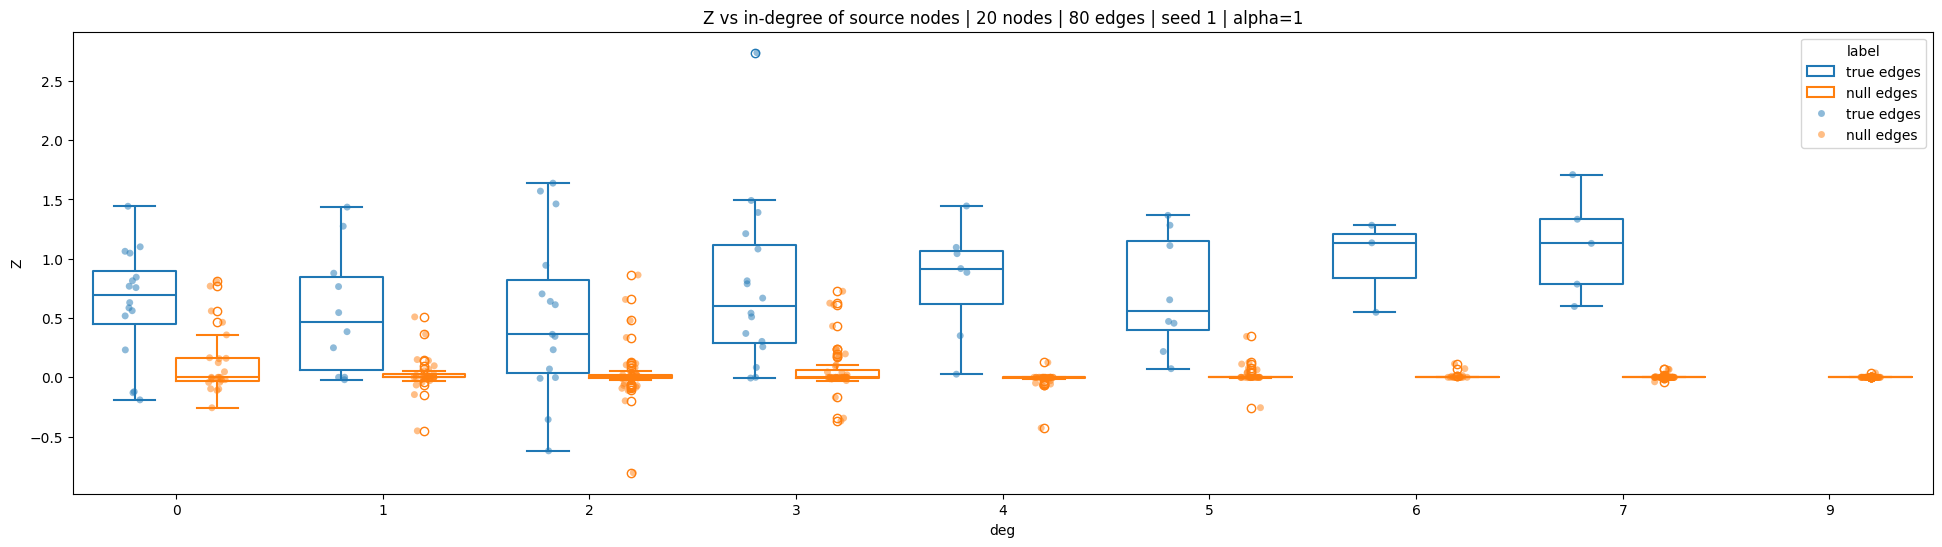

In [45]:
df = sys_z0_vs_deg_box(n_nodes, f'v41/v{n_nodes}_alpha_sklearn', notes='alpha=1')

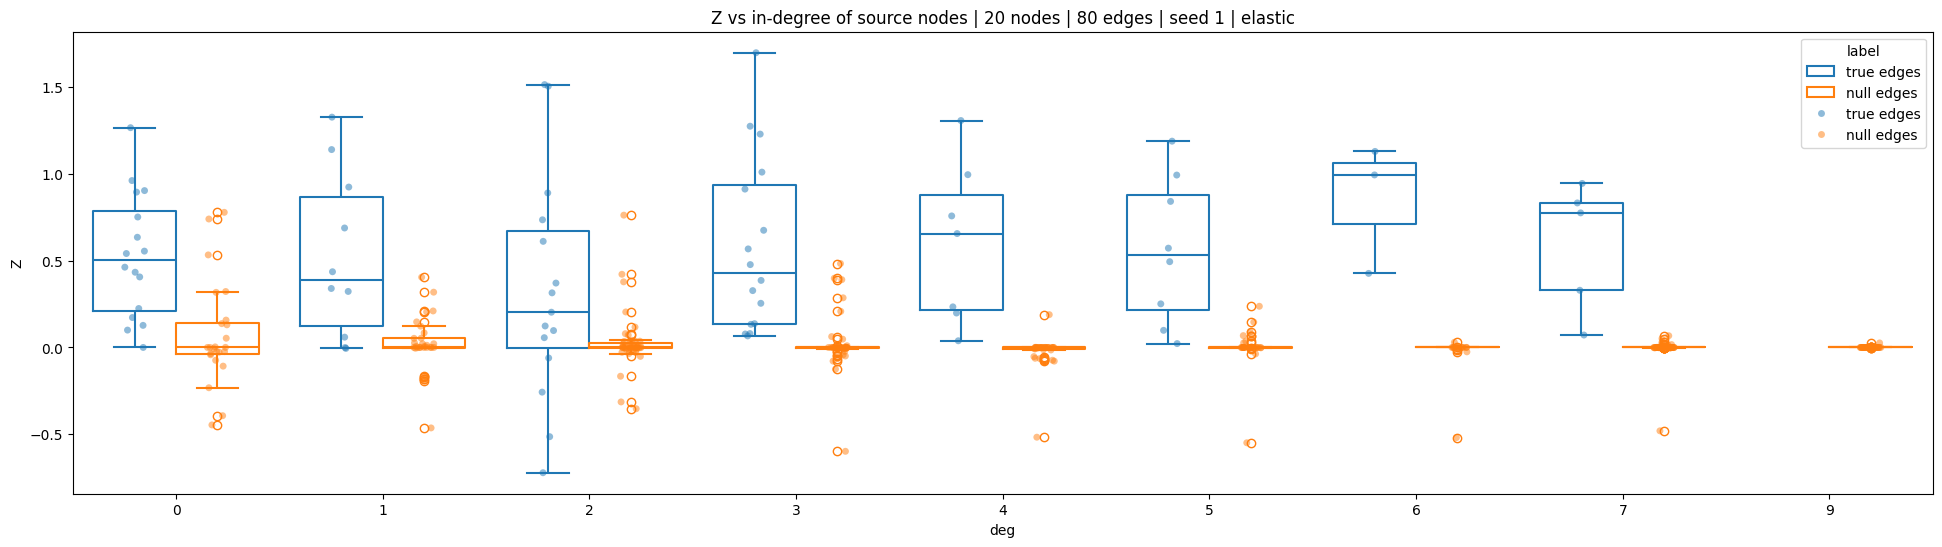

In [46]:
df = sys_z0_vs_deg_box(n_nodes, f'v41/v{n_nodes}_elastic', notes='elastic')

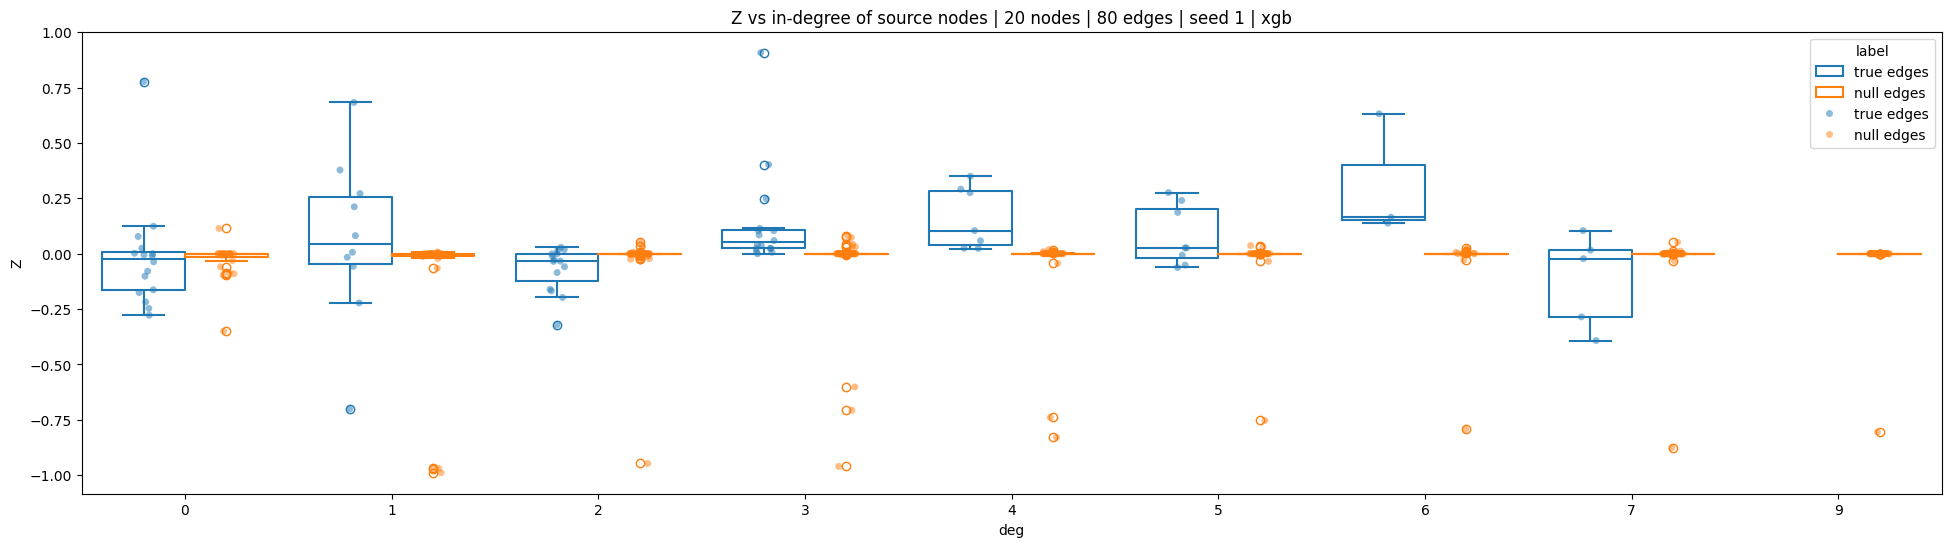

In [47]:
df = sys_z0_vs_deg_box(n_nodes, f'v41/v{n_nodes}_xgb', notes='xgb')

# 40 nodes

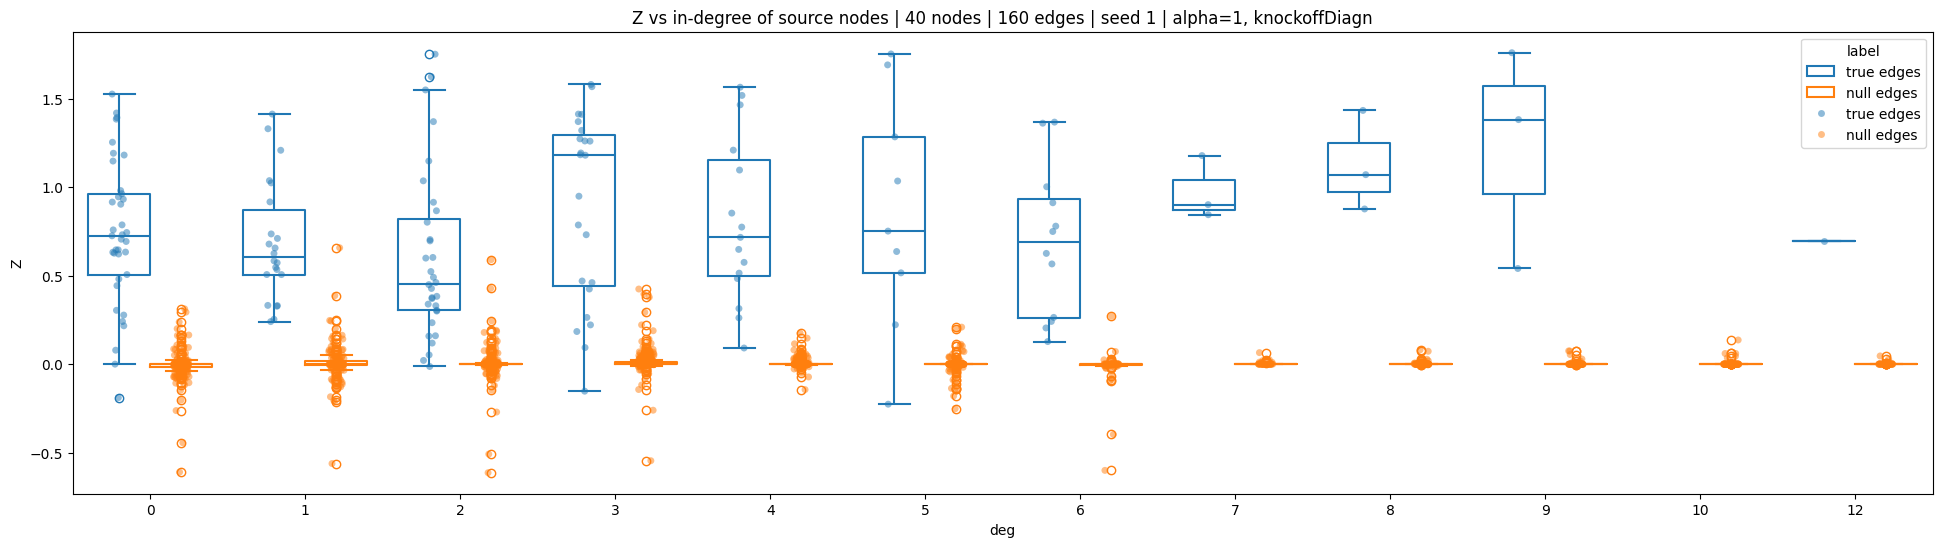

In [52]:
df = sys_z0_vs_deg_box(40, 'v41/v40_alpha_sklearn', notes='alpha=1, knockoffDiagn')

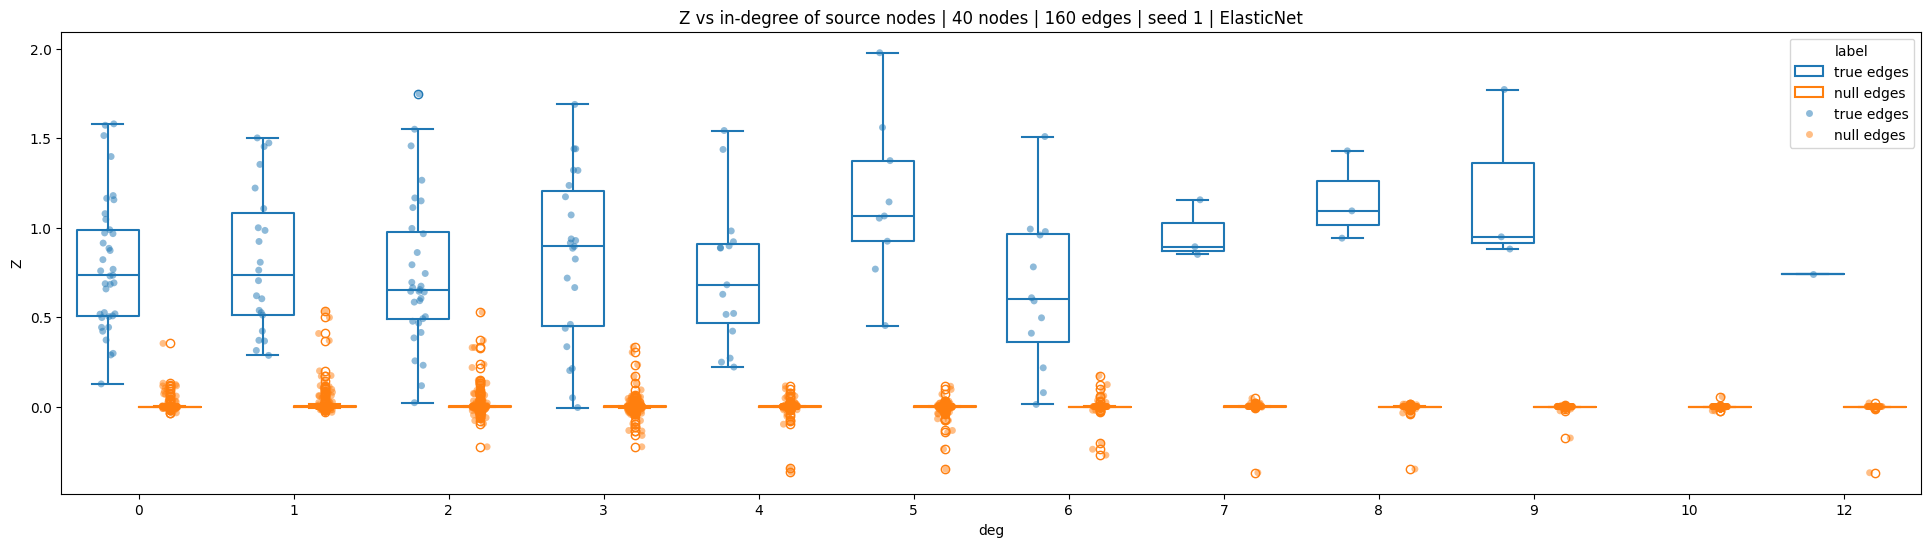

In [14]:
df = sys_z0_vs_deg_box(40, 'v41/v40_elastic', notes='ElasticNet')

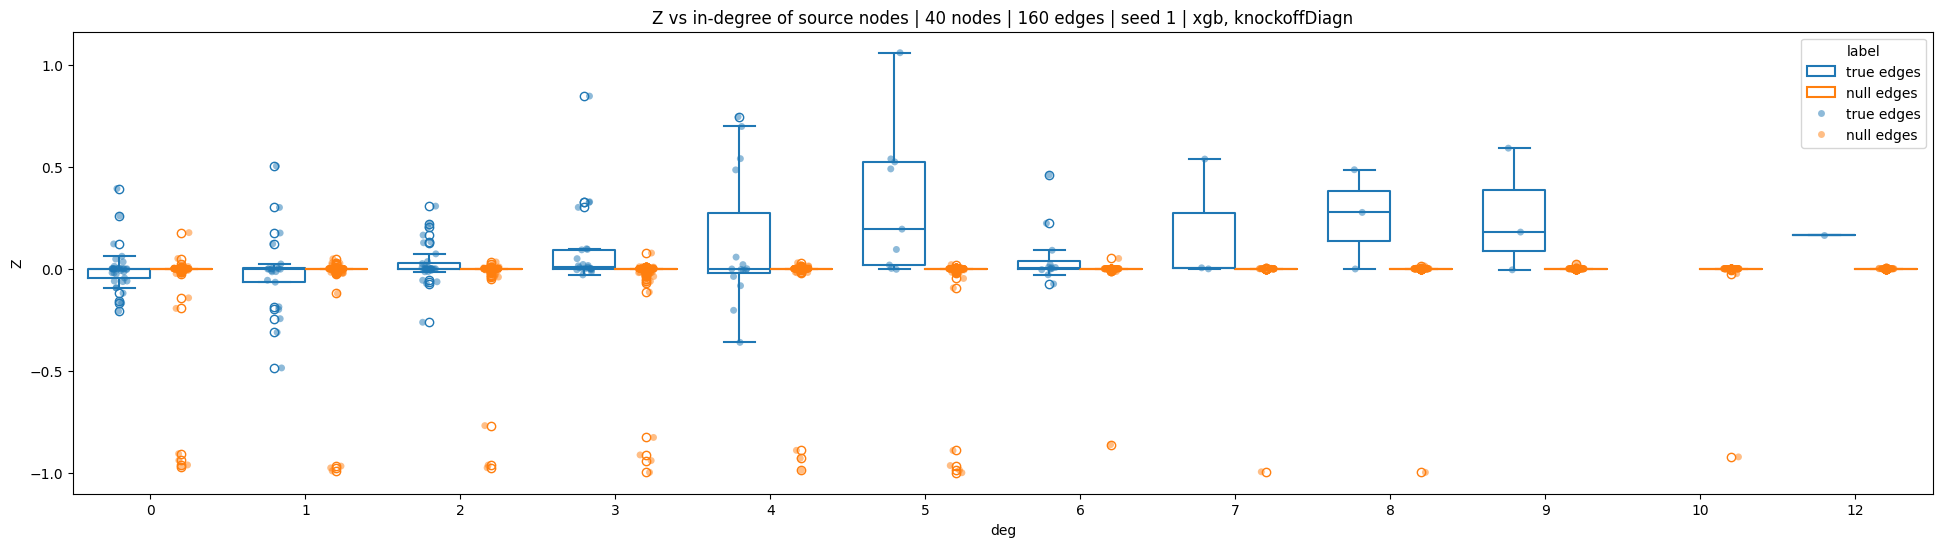

In [55]:
df = sys_z0_vs_deg_box(40, 'v41/v40_xgb', notes='xgb, knockoffDiagn')

## distribution of generated knockoff and original X, lasso(default alpha) vs lasso(sklearn alpha) vs elastic vs xgb vs X

Text(0.5, 1.0, 'knockoff vs X | 40 nodes, 160 edges, seed=1')

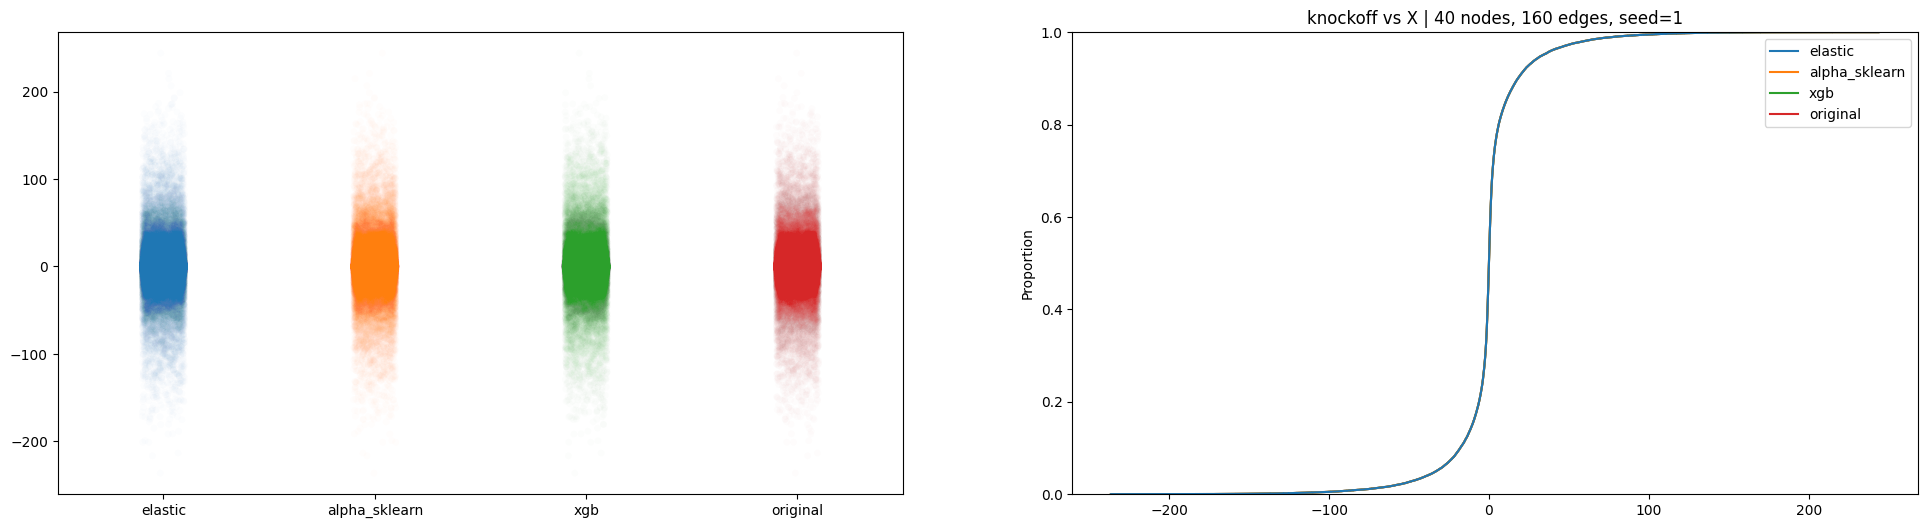

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(24, 6))
X_tilde_dict = {}
data_version = 41
n_nodes = 40
method_list = ['elastic', 'alpha_sklearn', 'xgb']
for method in method_list:
    with open(f'/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v{data_version}/v{n_nodes}_{method}/knockoff/knockoff_1.pkl', 'rb') as f:
        X_tilde_dict[method] = pickle.load(f).flatten()

with open(f'/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v11/v{n_nodes}/X/X_1.pkl', 'rb') as f:
        X_tilde_dict['original'] = pickle.load(f)['X'].flatten()

sns.stripplot(X_tilde_dict, alpha=0.01, ax=axs[0])
sns.ecdfplot(X_tilde_dict, ax=axs[1])
plt.title(f"knockoff vs X | {n_nodes} nodes, {n_nodes * 4} edges, seed=1")

# 80 nodes

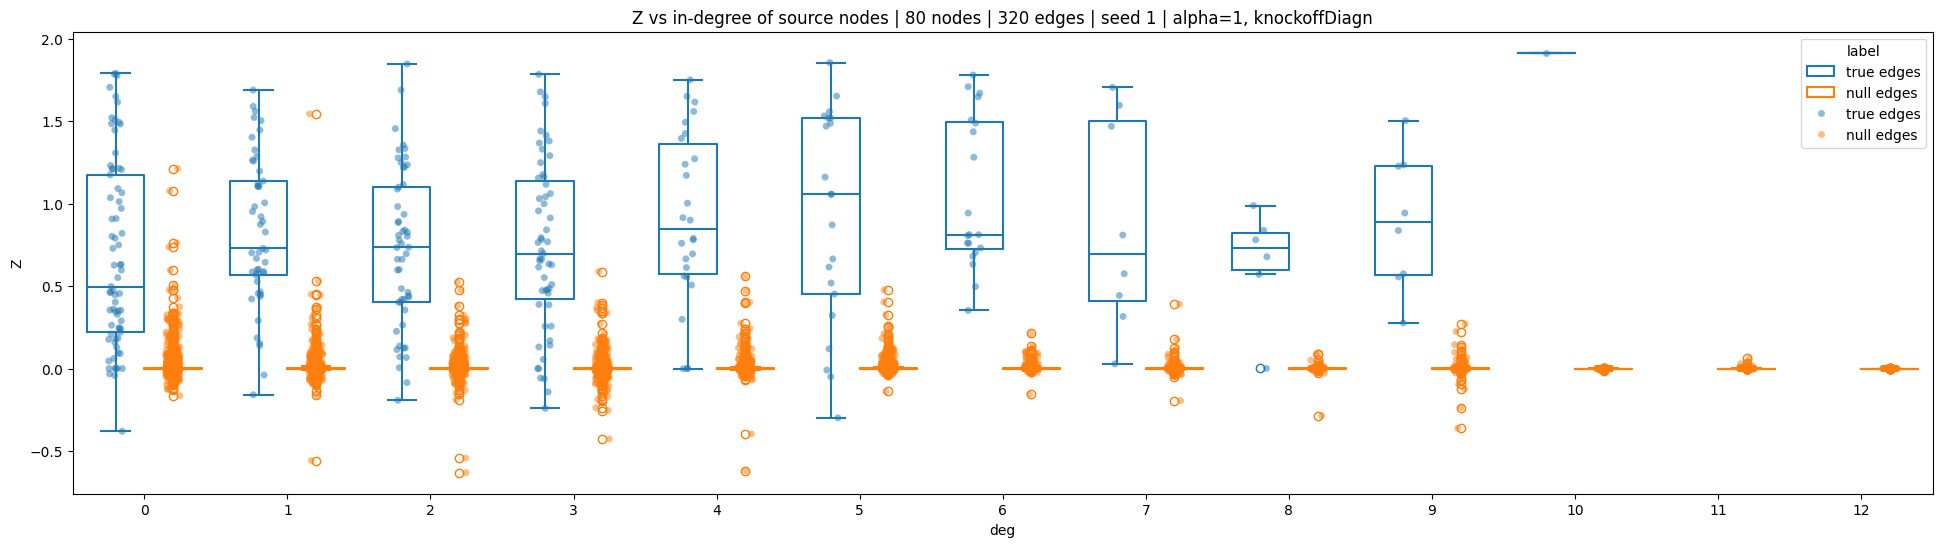

In [53]:
df = sys_z0_vs_deg_box(80, 'v41/v80_alpha_sklearn', notes='alpha=1, knockoffDiagn')

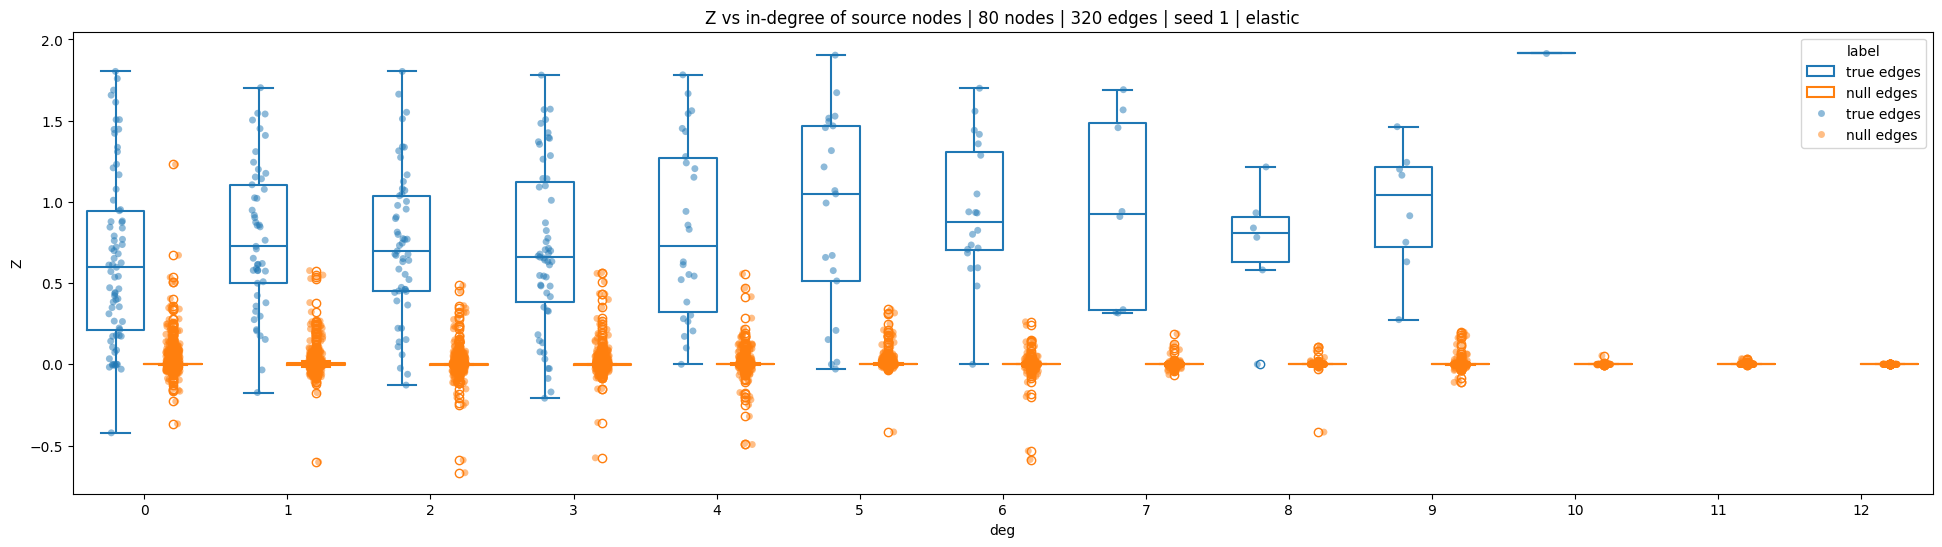

In [18]:
df = sys_z0_vs_deg_box(80, 'v41/v80_elastic', notes='elastic')

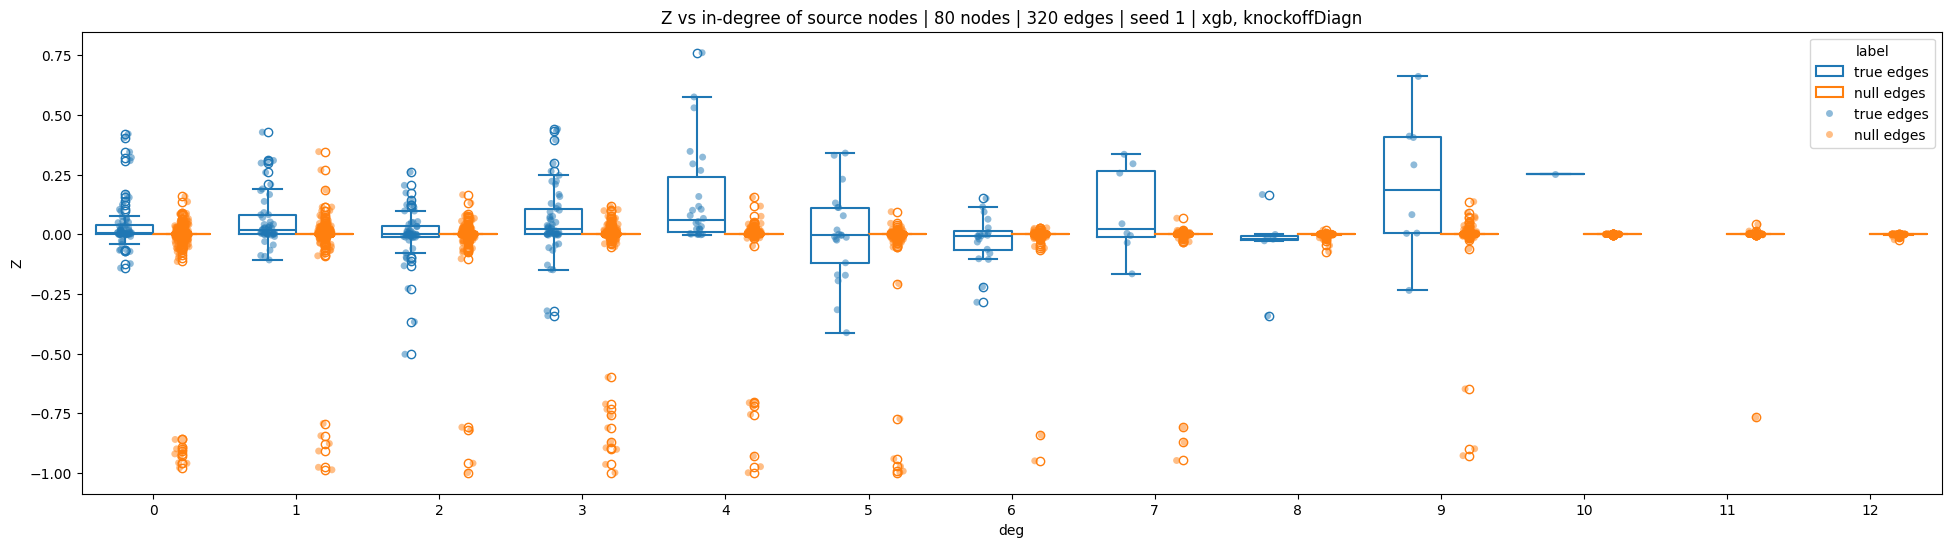

In [56]:
df = sys_z0_vs_deg_box(80, 'v41/v80_xgb', notes='xgb, knockoffDiagn')

In [2]:
n_nodes = 80
version_path = 'v41/v80_xgb'
seed=1

X, B_true, W_est, W_true = load_data(n_nodes, seed, f"{version_path}")
W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
Z11_21 = get_Z(W_est, n_nodes=n_nodes)

out_deg = B_true.sum(axis=1)
in_deg = B_true.sum(axis=0)

In [3]:
mask = (~B_true) & (Z11_21 < -0.5)

In [4]:
np.where(mask)

(array([ 1,  3,  5,  6,  7,  8, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22,
        24, 25, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 39, 40, 42, 43, 45,
        46, 48, 49, 50, 52, 55, 56, 59, 60, 61, 62, 65, 68, 71, 72, 74, 77]),
 array([ 1,  3,  5,  6,  7,  8, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22,
        24, 25, 26, 27, 28, 30, 31, 33, 34, 36, 37, 38, 39, 40, 42, 43, 45,
        46, 48, 49, 50, 52, 55, 56, 59, 60, 61, 62, 65, 68, 71, 72, 74, 77]))

In [7]:
W21[mask]

array([0.97361035, 0.98688046, 0.84164866, 0.90117816, 0.87669494,
       0.73330573, 0.92013051, 0.70094323, 0.75871605, 0.94782692,
       0.89290936, 0.75531309, 0.71137411, 0.86968812, 0.96411141,
       0.89903533, 0.87190359, 0.97633645, 0.95777087, 0.92763248,
       0.82025714, 0.99838284, 0.99896774, 0.99907405, 0.99874587,
       0.85933906, 0.90824479, 0.80915294, 0.76756661, 0.70583254,
       0.95932866, 0.72076928, 0.59912234, 0.97252016, 0.84416654,
       0.94069897, 0.9493125 , 0.89474669, 0.79298957, 0.85971252,
       0.95977872, 0.647938  , 0.77286641, 0.99232564, 0.80844503,
       0.90996247, 0.92965614, 0.9295717 , 0.97846406, 0.89859504,
       0.81141379])

Text(0.5, 1.0, 'knockoff vs X | 80 nodes, 320 edges, seed=1')

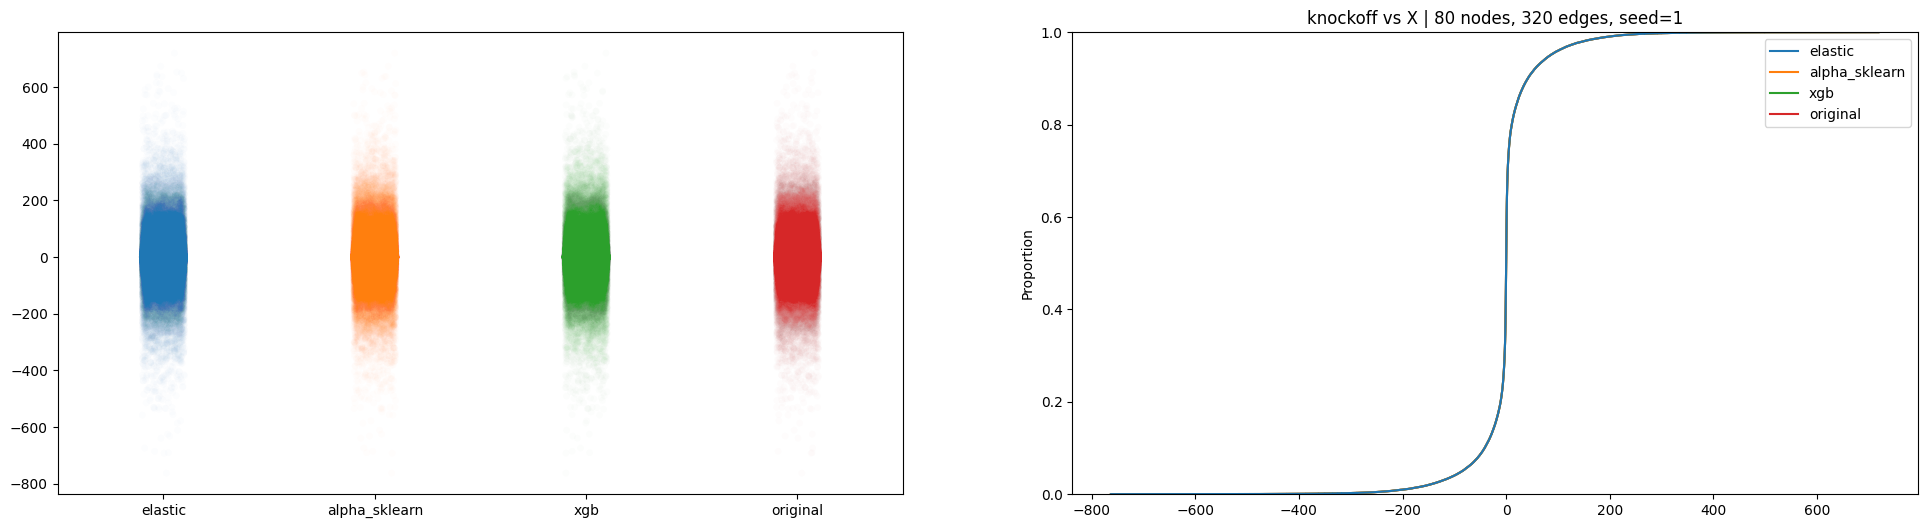

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(24, 6))
X_tilde_dict = {}
data_version = 41
n_nodes = 80
method_list = ['elastic', 'alpha_sklearn', 'xgb']
for method in method_list:
    with open(f'/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v{data_version}/v{n_nodes}_{method}/knockoff/knockoff_1.pkl', 'rb') as f:
        X_tilde_dict[method] = pickle.load(f).flatten()

with open(f'/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v11/v{n_nodes}/X/X_1.pkl', 'rb') as f:
        X_tilde_dict['original'] = pickle.load(f)['X'].flatten()

sns.stripplot(X_tilde_dict, alpha=0.01, ax=axs[0])
sns.ecdfplot(X_tilde_dict, ax=axs[1])
plt.title(f"knockoff vs X | {n_nodes} nodes, {n_nodes * 4} edges, seed=1")

# 100 nodes

In [48]:
n_nodes = 100

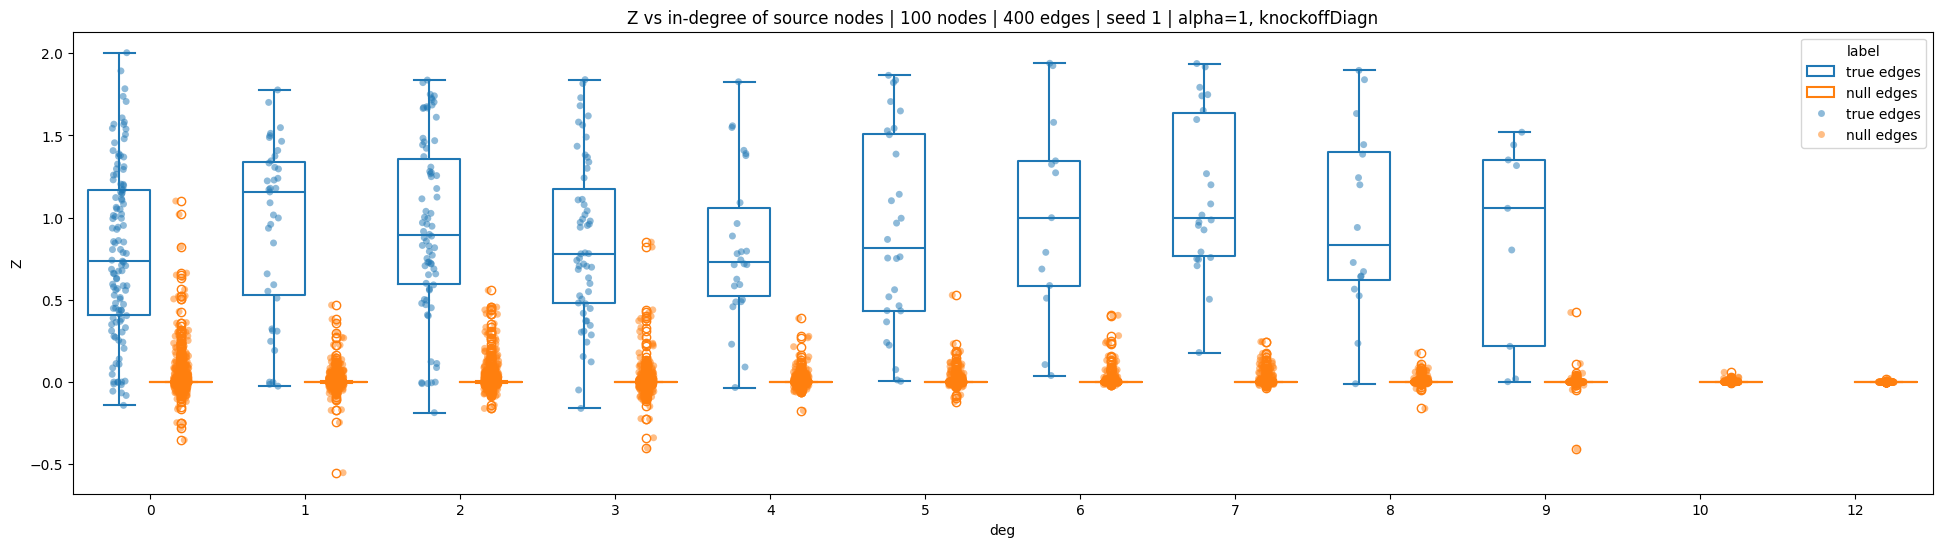

In [54]:
df = sys_z0_vs_deg_box(n_nodes, f'v41/v{n_nodes}_alpha_sklearn', notes='alpha=1, knockoffDiagn')

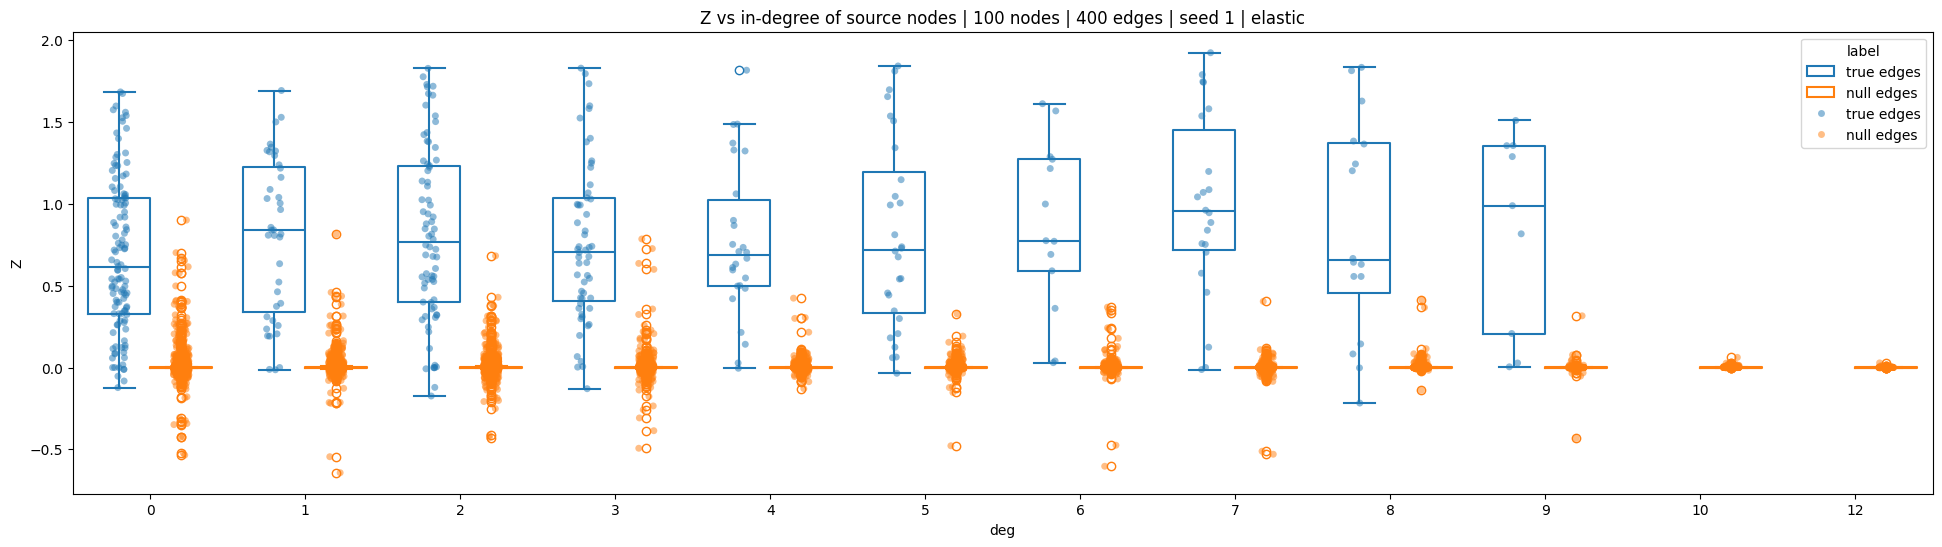

In [50]:
df = sys_z0_vs_deg_box(n_nodes, f'v41/v{n_nodes}_elastic', notes='elastic')

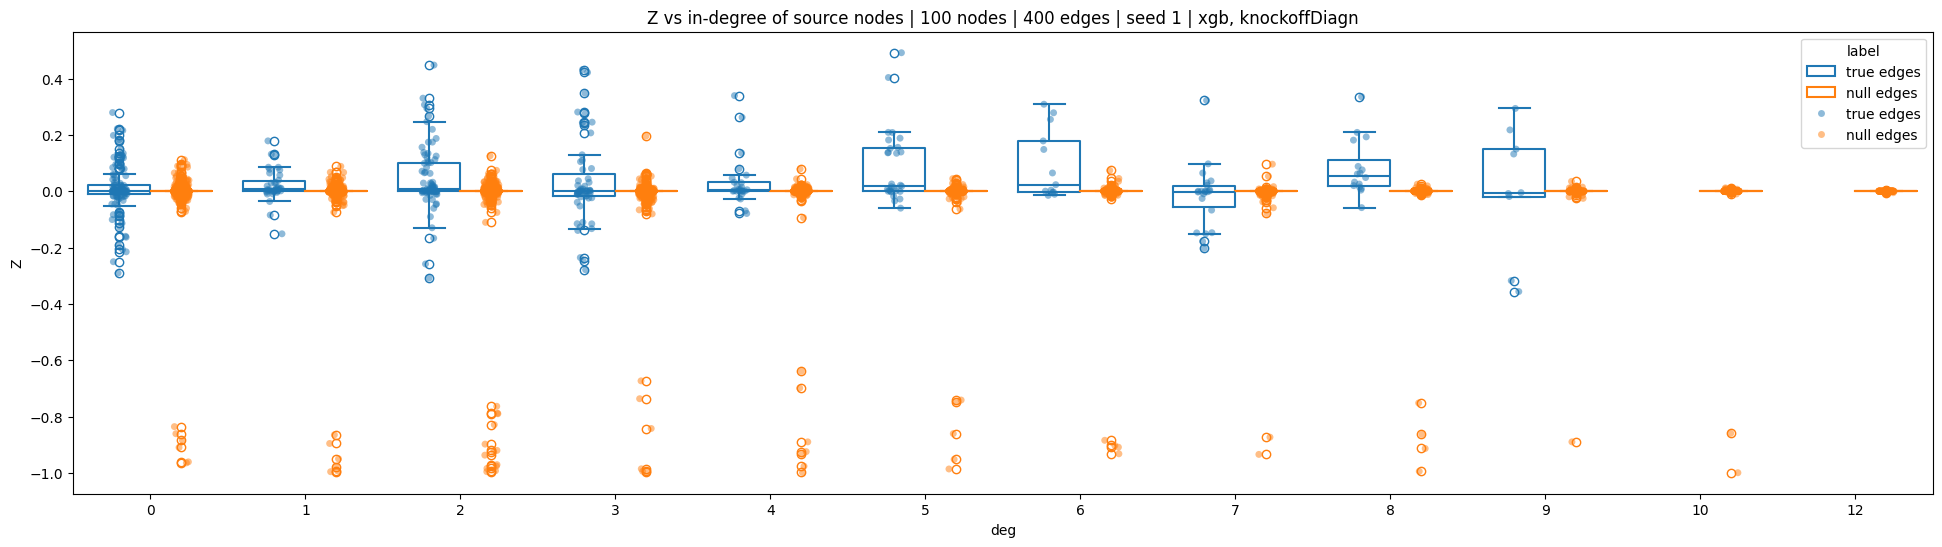

In [57]:
df = sys_z0_vs_deg_box(n_nodes, f'v41/v{n_nodes}_xgb', notes='xgb, knockoffDiagn')

In [ ]:
df = sys_z0_vs_deg_box(40, 'v41/v40_alpha_sklearn', notes='alpha=1')

# Misc

In [58]:
G = nx.path_graph(4)

In [59]:
G.edges()

EdgeView([(0, 1), (1, 2), (2, 3)])

In [61]:
G.subgraph(0).nodes()

NodeView((0,))

In [70]:
nx.is_directed(nx.ego_graph(G, 3, 1))

False